### Mercedes-Benz : Time Estimator

In [1]:
# import Library for data Processing
import numpy as np
import pandas as pd

# import for data preprocessing

from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import SelectFromModel

# For Prediction
import xgboost as xgb

#from sklearn.base import BaseEstimator,TransformerMixin,ClassifierMixin

# PCA
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA


# For Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Colours
color = sns.color_palette()
%matplotlib inline

# Ignore Wrnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Read data into pandas dataframe
orig_train_df = pd.read_csv("train.csv")
orig_test_df = pd.read_csv("test.csv")

#Final_prediction = pd.read_csv("Final_prediction.csv")

In [3]:
orig_train_df.head()

,ID,y,X0,X1,X2,X3,X4,X5,X6,X8,...,X375,X376,X377,X378,X379,X380,X382,X383,X384,X385
0,0,130.81,k,v,at,a,d,u,j,o,...,0,0,1,0,0,0,0,0,0,0
1,6,88.53,k,t,av,e,d,y,l,o,...,1,0,0,0,0,0,0,0,0,0
2,7,76.26,az,w,n,c,d,x,j,x,...,0,0,0,0,0,0,1,0,0,0
3,9,80.62,az,t,n,f,d,x,l,e,...,0,0,0,0,0,0,0,0,0,0
4,13,78.02,az,v,n,f,d,h,d,n,...,0,0,0,0,0,0,0,0,0,0


In [4]:
orig_test_df.head()

,ID,X0,X1,X2,X3,X4,X5,X6,X8,X10,...,X375,X376,X377,X378,X379,X380,X382,X383,X384,X385
0,1,az,v,n,f,d,t,a,w,0,...,0,0,0,1,0,0,0,0,0,0
1,2,t,b,ai,a,d,b,g,y,0,...,0,0,1,0,0,0,0,0,0,0
2,3,az,v,as,f,d,a,j,j,0,...,0,0,0,1,0,0,0,0,0,0
3,4,az,l,n,f,d,z,l,n,0,...,0,0,0,1,0,0,0,0,0,0
4,5,w,s,as,c,d,y,i,m,0,...,1,0,0,0,0,0,0,0,0,0


In [5]:
print('min: {} max: {} mean: {} std: {}'.format(min(orig_train_df['y'].values), max(orig_train_df['y'].values), orig_train_df['y'].values.mean(), orig_train_df['y'].values.std()))
print('Count of values above 180: {}'.format(np.sum(orig_train_df['y'].values > 180)))

min: 72.11 max: 265.32 mean: 100.66931812782134 std: 12.6778749695168
Count of values above 180: 1


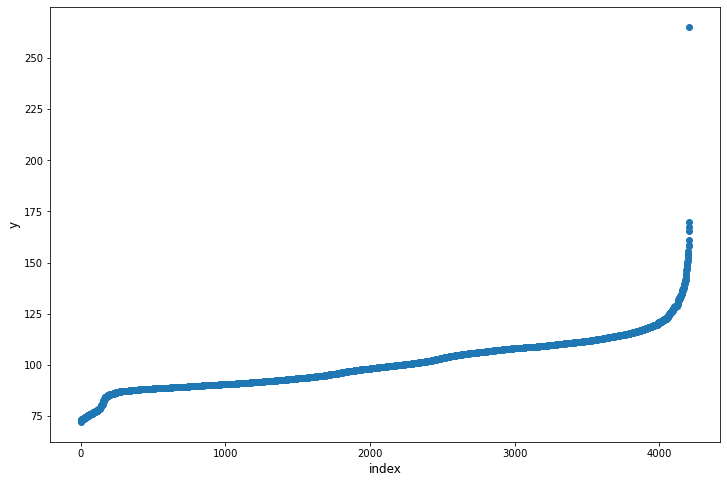

In [6]:
#Analysis on our predicted variable 'y'
plt.figure(figsize = (12,8))
plt.scatter(range(orig_train_df.shape[0]), np.sort(orig_train_df.y.values))
plt.xlabel('index', fontsize=12)
plt.ylabel('y', fontsize=12)
plt.show()

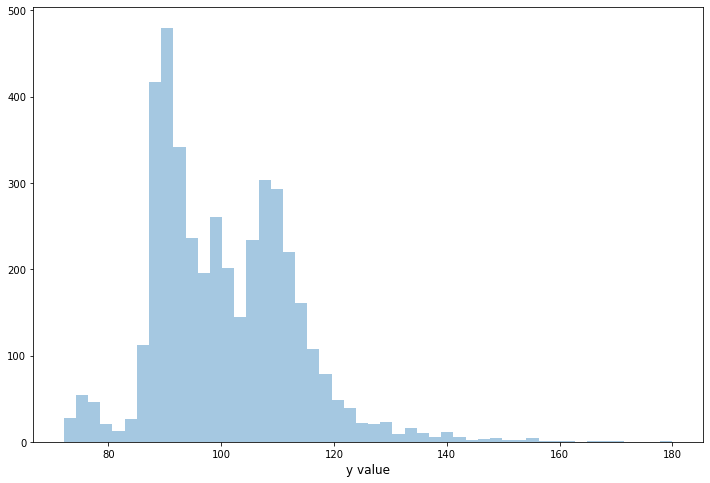

In [7]:
# Hence we can see a single Outlier at the top of the plot. So, we can see the distribution of data

UpperLimit = 180
orig_train_df['y'].iloc[orig_train_df['y'] > UpperLimit] = UpperLimit

plt.figure(figsize = (12,8))
sns.distplot(orig_train_df.y.values, bins=50, kde = False)
plt.xlabel('y value', fontsize=12)
plt.show()

### 0.01. * If for any column(s), the variance is equal to zero, then you need to remove those variable(s).

In [8]:
orig_train_df.var()

ID      5.941936e+06
y       1.558194e+02
X10     1.313092e-02
X11     0.000000e+00
X12     6.945713e-02
            ...     
X380    8.014579e-03
X382    7.546747e-03
X383    1.660732e-03
X384    4.750593e-04
X385    1.423823e-03
Length: 370, dtype: float64

In [9]:
# To find the variance in Columns if any
variance_zeros = orig_train_df.var()[orig_train_df.var()== 0].index.values
variance_zeros

array(['X11', 'X93', 'X107', 'X233', 'X235', 'X268', 'X289', 'X290',
       'X293', 'X297', 'X330', 'X347'], dtype=object)

### * Check for null and unique values for test and train sets

In [10]:
orig_train_df.isnull().any

<bound method NDFrame._add_numeric_operations.<locals>.any of          ID      y     X0     X1     X2     X3     X4     X5     X6     X8  \
0     False  False  False  False  False  False  False  False  False  False   
1     False  False  False  False  False  False  False  False  False  False   
2     False  False  False  False  False  False  False  False  False  False   
3     False  False  False  False  False  False  False  False  False  False   
4     False  False  False  False  False  False  False  False  False  False   
...     ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
4204  False  False  False  False  False  False  False  False  False  False   
4205  False  False  False  False  False  False  False  False  False  False   
4206  False  False  False  False  False  False  False  False  False  False   
4207  False  False  False  False  False  False  False  False  False  False   
4208  False  False  False  False  False  False  False  False  False  False   

 

In [11]:
orig_train_df.isnull().sum().count()

378

In [12]:
orig_train_df.nunique

<bound method DataFrame.nunique of         ID       y  X0 X1  X2 X3 X4  X5 X6 X8  ...  X375  X376  X377  X378  \
0        0  130.81   k  v  at  a  d   u  j  o  ...     0     0     1     0   
1        6   88.53   k  t  av  e  d   y  l  o  ...     1     0     0     0   
2        7   76.26  az  w   n  c  d   x  j  x  ...     0     0     0     0   
3        9   80.62  az  t   n  f  d   x  l  e  ...     0     0     0     0   
4       13   78.02  az  v   n  f  d   h  d  n  ...     0     0     0     0   
...    ...     ...  .. ..  .. .. ..  .. .. ..  ...   ...   ...   ...   ...   
4204  8405  107.39  ak  s  as  c  d  aa  d  q  ...     1     0     0     0   
4205  8406  108.77   j  o   t  d  d  aa  h  h  ...     0     1     0     0   
4206  8412  109.22  ak  v   r  a  d  aa  g  e  ...     0     0     1     0   
4207  8415   87.48  al  r   e  f  d  aa  l  u  ...     0     0     0     0   
4208  8417  110.85   z  r  ae  c  d  aa  g  w  ...     1     0     0     0   

      X379  X380  X382  X383

In [13]:
#To find the different data types present in our Dataset
dtype=orig_train_df.dtypes.reset_index()
dtype.columns = ["No.Data Type", "Columns"]
dtype.groupby("Columns").aggregate('count').reset_index()

,Columns,No.Data Type
0,int64,369
1,float64,1
2,object,8


#### Hence, we can see that there are 8 objects, One float and 369 types of integers


In [14]:
dtype.loc[:10,:]

,No.Data Type,Columns
0,ID,int64
1,y,float64
2,X0,object
3,X1,object
4,X2,object
5,X3,object
6,X4,object
7,X5,object
8,X6,object
9,X8,object


In [15]:
obj_dtype = orig_train_df.select_dtypes(include = [object])
obj_dtype

,X0,X1,X2,X3,X4,X5,X6,X8
0,k,v,at,a,d,u,j,o
1,k,t,av,e,d,y,l,o
2,az,w,n,c,d,x,j,x
3,az,t,n,f,d,x,l,e
4,az,v,n,f,d,h,d,n
...,...,...,...,...,...,...,...,...
4204,ak,s,as,c,d,aa,d,q
4205,j,o,t,d,d,aa,h,h
4206,ak,v,r,a,d,aa,g,e
4207,al,r,e,f,d,aa,l,u


### * Apply label encoder

In [16]:
obj_dtype_cols = obj_dtype.columns
obj_dtype_cols

Index(['X0', 'X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X8'], dtype='object')

In [17]:
#Importing Library for label Encoding to encode String to Numeric
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

In [18]:
orig_train_df['X0'] = le.fit_transform(orig_train_df['X0'])
orig_train_df['X1'] = le.fit_transform(orig_train_df['X1'])
orig_train_df['X2'] = le.fit_transform(orig_train_df['X2'])
orig_train_df['X3'] = le.fit_transform(orig_train_df['X3'])
orig_train_df['X4'] = le.fit_transform(orig_train_df['X4'])
orig_train_df['X5'] = le.fit_transform(orig_train_df['X5'])
orig_train_df['X6'] = le.fit_transform(orig_train_df['X6'])
orig_train_df['X8'] = le.fit_transform(orig_train_df['X8'])

In [19]:
orig_train_df.head()

,ID,y,X0,X1,X2,X3,X4,X5,X6,X8,...,X375,X376,X377,X378,X379,X380,X382,X383,X384,X385
0,0,130.81,32,23,17,0,3,24,9,14,...,0,0,1,0,0,0,0,0,0,0
1,6,88.53,32,21,19,4,3,28,11,14,...,1,0,0,0,0,0,0,0,0,0
2,7,76.26,20,24,34,2,3,27,9,23,...,0,0,0,0,0,0,1,0,0,0
3,9,80.62,20,21,34,5,3,27,11,4,...,0,0,0,0,0,0,0,0,0,0
4,13,78.02,20,23,34,5,3,12,3,13,...,0,0,0,0,0,0,0,0,0,0


### Scaling the Data

In [20]:
# Import required library from sklearn
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [21]:
train_scaled = scaler.fit_transform(orig_train_df.iloc[:, 1:])

In [22]:
train_scaled = pd.DataFrame(train_scaled)
train_scaled.head()

,0,1,2,3,4,5,6,7,8,9,...,367,368,369,370,371,372,373,374,375,376
0,2.416495,0.163012,1.393488,-0.028122,-1.678270,0.028938,1.292117,0.751787,0.339445,-0.116122,...,-0.684167,-0.246447,1.475332,-0.14528,-0.097952,-0.090243,-0.087527,-0.040815,-0.021804,-0.037783
1,-0.970978,0.163012,1.159021,0.155388,0.620969,0.028938,1.776974,1.437511,0.339445,-0.116122,...,1.461630,-0.246447,-0.677814,-0.14528,-0.097952,-0.090243,-0.087527,-0.040815,-0.021804,-0.037783
2,-1.954050,-0.710560,1.510721,1.531709,-0.528650,0.028938,1.655760,0.751787,1.618389,-0.116122,...,-0.684167,-0.246447,-0.677814,-0.14528,-0.097952,-0.090243,11.425027,-0.040815,-0.021804,-0.037783
3,-1.604727,-0.710560,1.159021,1.531709,1.195779,0.028938,1.655760,1.437511,-1.081605,-0.116122,...,-0.684167,-0.246447,-0.677814,-0.14528,-0.097952,-0.090243,-0.087527,-0.040815,-0.021804,-0.037783
4,-1.813039,-0.710560,1.393488,1.531709,1.195779,0.028938,-0.162454,-1.305384,0.197340,-0.116122,...,-0.684167,-0.246447,-0.677814,-0.14528,-0.097952,-0.090243,-0.087527,-0.040815,-0.021804,-0.037783


In [23]:
train_scaled.describe()

,0,1,2,3,4,5,6,7,8,9,...,367,368,369,370,371,372,373,374,375,376
count,4.209000e+03,4.209000e+03,4.209000e+03,4.209000e+03,4.209000e+03,4.209000e+03,4.209000e+03,4.209000e+03,4.209000e+03,4.209000e+03,...,4.209000e+03,4.209000e+03,4.209000e+03,4.209000e+03,4.209000e+03,4.209000e+03,4.209000e+03,4.209000e+03,4.209000e+03,4.209000e+03
mean,-9.178266e-16,5.011698e-18,-1.237151e-15,-5.151498e-16,-2.304590e-16,5.653970e-16,1.452865e-15,-7.443691e-17,7.280151e-18,1.410068e-16,...,6.054659e-16,-3.402389e-15,-5.202143e-16,-1.749610e-16,1.320457e-15,2.597510e-17,8.829557e-16,2.532095e-16,3.698633e-16,-2.143655e-16
std,1.000119e+00,1.000119e+00,1.000119e+00,1.000119e+00,1.000119e+00,1.000119e+00,1.000119e+00,1.000119e+00,1.000119e+00,1.000119e+00,...,1.000119e+00,1.000119e+00,1.000119e+00,1.000119e+00,1.000119e+00,1.000119e+00,1.000119e+00,1.000119e+00,1.000119e+00,1.000119e+00
min,-2.286548e+00,-2.166513e+00,-1.302882e+00,-1.587952e+00,-1.678270e+00,-4.057130e+01,-1.617026e+00,-2.333970e+00,-1.650025e+00,-1.161216e-01,...,-6.841675e-01,-2.464465e-01,-6.778137e-01,-1.452799e-01,-9.795217e-02,-9.024252e-02,-8.752714e-02,-4.081511e-02,-2.180363e-02,-3.778296e-02
25%,-7.875030e-01,-7.833574e-01,-9.511815e-01,-8.539142e-01,-5.286503e-01,2.893816e-02,-1.010954e+00,-2.767985e-01,-9.394998e-01,-1.161216e-01,...,-6.841675e-01,-2.464465e-01,-6.778137e-01,-1.452799e-01,-9.795217e-02,-9.024252e-02,-8.752714e-02,-4.081511e-02,-2.180363e-02,-3.778296e-02
50%,-1.201036e-01,3.814051e-01,2.211532e-01,-1.198763e-01,-5.286503e-01,2.893816e-02,2.011887e-01,6.606344e-02,-8.687006e-02,-1.161216e-01,...,-6.841675e-01,-2.464465e-01,-6.778137e-01,-1.452799e-01,-9.795217e-02,-9.024252e-02,-8.752714e-02,-4.081511e-02,-2.180363e-02,-3.778296e-02
75%,6.698793e-01,9.637863e-01,1.041787e+00,7.059164e-01,1.195779e+00,2.893816e-02,9.284744e-01,7.517872e-01,9.078647e-01,-1.161216e-01,...,1.461630e+00,-2.464465e-01,1.475332e+00,-1.452799e-01,-9.795217e-02,-9.024252e-02,-8.752714e-02,-4.081511e-02,-2.180363e-02,-3.778296e-02
max,6.357596e+00,1.182179e+00,1.745188e+00,2.357502e+00,1.770589e+00,2.893816e-02,1.776974e+00,1.437511e+00,1.760494e+00,8.611662e+00,...,1.461630e+00,4.057675e+00,1.475332e+00,6.883263e+00,1.020906e+01,1.108125e+01,1.142503e+01,2.450073e+01,4.586393e+01,2.646696e+01


### Performing Dimensionality Reduction

In [24]:
from sklearn.decomposition import PCA

pca = PCA()

In [25]:
pca.fit(train_scaled.iloc[:, 1:])

PCA()

In [26]:
variance = pca.explained_variance_ratio_
variance.shape

(376,)

In [27]:
pca1 = PCA(n_components = 30)

In [28]:
p_components = pca1.fit_transform(train_scaled.iloc[:, 1:])

In [29]:
X = pd.DataFrame(p_components)

In [30]:
y = train_scaled[0]

In [31]:
# Librari import & Splitting into train & test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)


In [32]:
##Changes WE Made
from sklearn.feature_selection import SelectKBest, mutual_info_regression

sel = SelectKBest(mutual_info_regression, k = 30)

In [33]:
sel.fit(X_train, y_train)
X_train = sel.transform(X_train)
X_test = sel.transform(X_test)
X_train

array([[12.41838766, -1.85353464,  4.07896087, ...,  0.4294684 ,
        -2.11451379, -1.54284022],
       [ 5.42025902, 20.47239838, -6.74865805, ...,  2.19699976,
         0.65390929, -0.53449856],
       [-2.19866628,  1.61069845,  5.71284557, ...,  0.28111073,
         0.40569163, -0.03374912],
       ...,
       [ 9.7747777 , -3.70916853, -2.41643754, ..., -0.31396085,
        -3.68914371, -1.62640879],
       [-1.75426697,  0.26391408, -0.36017131, ...,  0.44810983,
        -1.42110182,  1.56995413],
       [12.33287137, -1.46876188,  2.12806801, ...,  0.35441941,
        -0.27208568, -0.7255333 ]])

In [34]:
X = orig_train_df[orig_train_df.columns[2:]]

### Model Building

In [35]:
# Linear Regression
from sklearn.linear_model import LinearRegression
lr = LinearRegression()

In [36]:
#fit the Model
lr.fit(X_train, y_train)

LinearRegression()

### Prediction Y

In [37]:
y_prediction = lr.predict(X_test)

### Accuracy checking with R_Score

In [38]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

In [39]:
r_score = r2_score(y_test, y_prediction)
r_score

0.4639318181242531

In [40]:
MAE = mean_absolute_error(y_test, y_prediction)
MAE

0.5056796181470748

In [41]:
MSE  = mean_squared_error(y_test, y_prediction)
MSE

0.5371481248935712

In [42]:
RMSE = np.sqrt(MSE)
RMSE

0.7329038988118233

In [43]:
test = pd.read_csv("test.csv")
test.head()

,ID,X0,X1,X2,X3,X4,X5,X6,X8,X10,...,X375,X376,X377,X378,X379,X380,X382,X383,X384,X385
0,1,az,v,n,f,d,t,a,w,0,...,0,0,0,1,0,0,0,0,0,0
1,2,t,b,ai,a,d,b,g,y,0,...,0,0,1,0,0,0,0,0,0,0
2,3,az,v,as,f,d,a,j,j,0,...,0,0,0,1,0,0,0,0,0,0
3,4,az,l,n,f,d,z,l,n,0,...,0,0,0,1,0,0,0,0,0,0
4,5,w,s,as,c,d,y,i,m,0,...,1,0,0,0,0,0,0,0,0,0


In [44]:
# To Find variables with Zero variance
test.var()[test.var() == 0]

X257    0.0
X258    0.0
X295    0.0
X296    0.0
X369    0.0
dtype: float64

In [45]:
test_new =test.drop(test.var()[test.var()==0].index.values, axis=1)


In [46]:
test_new.size

1565748

In [47]:
test_new.shape

(4209, 372)

In [48]:
test_new.isnull().sum()

ID      0
X0      0
X1      0
X2      0
X3      0
       ..
X380    0
X382    0
X383    0
X384    0
X385    0
Length: 372, dtype: int64

In [49]:
test_new.dropna()

,ID,X0,X1,X2,X3,X4,X5,X6,X8,X10,...,X375,X376,X377,X378,X379,X380,X382,X383,X384,X385
0,1,az,v,n,f,d,t,a,w,0,...,0,0,0,1,0,0,0,0,0,0
1,2,t,b,ai,a,d,b,g,y,0,...,0,0,1,0,0,0,0,0,0,0
2,3,az,v,as,f,d,a,j,j,0,...,0,0,0,1,0,0,0,0,0,0
3,4,az,l,n,f,d,z,l,n,0,...,0,0,0,1,0,0,0,0,0,0
4,5,w,s,as,c,d,y,i,m,0,...,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4204,8410,aj,h,as,f,d,aa,j,e,0,...,0,0,0,0,0,0,0,0,0,0
4205,8411,t,aa,ai,d,d,aa,j,y,0,...,0,1,0,0,0,0,0,0,0,0
4206,8413,y,v,as,f,d,aa,d,w,0,...,0,0,0,0,0,0,0,0,0,0
4207,8414,ak,v,as,a,d,aa,c,q,0,...,0,0,1,0,0,0,0,0,0,0


In [50]:
test_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4209 entries, 0 to 4208
Columns: 372 entries, ID to X385
dtypes: int64(364), object(8)
memory usage: 11.9+ MB


In [51]:
test_new.select_dtypes(object)

,X0,X1,X2,X3,X4,X5,X6,X8
0,az,v,n,f,d,t,a,w
1,t,b,ai,a,d,b,g,y
2,az,v,as,f,d,a,j,j
3,az,l,n,f,d,z,l,n
4,w,s,as,c,d,y,i,m
...,...,...,...,...,...,...,...,...
4204,aj,h,as,f,d,aa,j,e
4205,t,aa,ai,d,d,aa,j,y
4206,y,v,as,f,d,aa,d,w
4207,ak,v,as,a,d,aa,c,q


In [52]:
new_columns = ['X0','X1','X2','X3','X4','X5','X6','X8']

In [53]:
test_new[new_columns] = test_new[new_columns].apply(le.fit_transform)
test_new.head()

,ID,X0,X1,X2,X3,X4,X5,X6,X8,X10,...,X375,X376,X377,X378,X379,X380,X382,X383,X384,X385
0,1,21,23,34,5,3,26,0,22,0,...,0,0,0,1,0,0,0,0,0,0
1,2,42,3,8,0,3,9,6,24,0,...,0,0,1,0,0,0,0,0,0,0
2,3,21,23,17,5,3,0,9,9,0,...,0,0,0,1,0,0,0,0,0,0
3,4,21,13,34,5,3,31,11,13,0,...,0,0,0,1,0,0,0,0,0,0
4,5,45,20,17,2,3,30,8,12,0,...,1,0,0,0,0,0,0,0,0,0


In [54]:
# Scaling test new data
test_scaled = scaler.fit_transform(test_new)

In [55]:
test_scaled = test_scaled = pd.DataFrame(test_scaled)

In [56]:
test_scaled.head()

,0,1,2,3,4,5,6,7,8,9,...,362,363,364,365,366,367,368,369,370,371
0,-1.737681,-0.625211,1.395760,1.586068,1.163082,0.036299,1.266652,-2.388888,1.488396,-0.139195,...,-0.695420,-0.228583,-0.673338,7.138835,-0.109645,-0.090243,-0.094174,-0.021804,-0.026707,-0.040815
1,-1.737269,0.754609,-0.945199,-0.956445,-1.651020,0.036299,-0.695011,-0.296602,1.773477,-0.139195,...,-0.695420,-0.228583,1.485138,-0.140079,-0.109645,-0.090243,-0.094174,-0.021804,-0.026707,-0.040815
2,-1.736856,-0.625211,1.395760,-0.076345,1.163082,0.036299,-1.733538,0.749541,-0.364632,-0.139195,...,-0.695420,-0.228583,-0.673338,7.138835,-0.109645,-0.090243,-0.094174,-0.021804,-0.026707,-0.040815
3,-1.736443,-0.625211,0.225281,1.586068,1.163082,0.036299,1.843611,1.446970,0.205531,-0.139195,...,-0.695420,-0.228583,-0.673338,7.138835,-0.109645,-0.090243,-0.094174,-0.021804,-0.026707,-0.040815
4,-1.736031,0.951726,1.044616,-0.076345,-0.525379,0.036299,1.728219,0.400827,0.062990,-0.139195,...,1.437979,-0.228583,-0.673338,-0.140079,-0.109645,-0.090243,-0.094174,-0.021804,-0.026707,-0.040815


In [57]:
test_scaled.describe()

,0,1,2,3,4,5,6,7,8,9,...,362,363,364,365,366,367,368,369,370,371
count,4.209000e+03,4.209000e+03,4.209000e+03,4.209000e+03,4.209000e+03,4.209000e+03,4.209000e+03,4.209000e+03,4.209000e+03,4.209000e+03,...,4.209000e+03,4.209000e+03,4.209000e+03,4.209000e+03,4.209000e+03,4.209000e+03,4.209000e+03,4.209000e+03,4.209000e+03,4.209000e+03
mean,-1.482249e-15,-4.911464e-17,3.031444e-15,-8.469770e-17,-1.903390e-16,-7.715509e-16,-9.561581e-15,-2.663454e-16,-1.047445e-16,5.026074e-16,...,4.283155e-16,-2.516888e-15,9.740631e-16,-5.382959e-16,1.409085e-15,2.986115e-16,-4.977605e-16,2.803913e-16,-5.448623e-16,-1.309174e-15
std,1.000119e+00,1.000119e+00,1.000119e+00,1.000119e+00,1.000119e+00,1.000119e+00,1.000119e+00,1.000119e+00,1.000119e+00,1.000119e+00,...,1.000119e+00,1.000119e+00,1.000119e+00,1.000119e+00,1.000119e+00,1.000119e+00,1.000119e+00,1.000119e+00,1.000119e+00,1.000119e+00
min,-1.737681e+00,-2.005032e+00,-1.296343e+00,-1.738757e+00,-1.651020e+00,-3.815900e+01,-1.733538e+00,-2.388888e+00,-1.647497e+00,-1.391947e-01,...,-6.954203e-01,-2.285826e-01,-6.733379e-01,-1.400789e-01,-1.096454e-01,-9.024252e-02,-9.417350e-02,-2.180363e-02,-2.670705e-02,-4.081511e-02
25%,-8.651341e-01,-6.909172e-01,-9.451993e-01,-7.608673e-01,-5.253793e-01,3.629870e-02,-1.041186e+00,-2.966019e-01,-9.347940e-01,-1.391947e-01,...,-6.954203e-01,-2.285826e-01,-6.733379e-01,-1.400789e-01,-1.096454e-01,-9.024252e-02,-9.417350e-02,-2.180363e-02,-2.670705e-02,-4.081511e-02
50%,-3.730904e-03,3.603747e-01,2.252805e-01,-7.634462e-02,-5.253793e-01,3.629870e-02,2.281245e-01,5.211246e-02,-7.955045e-02,-1.391947e-01,...,-6.954203e-01,-2.285826e-01,-6.733379e-01,-1.400789e-01,-1.096454e-01,-9.024252e-02,-9.417350e-02,-2.180363e-02,-2.670705e-02,-4.081511e-02
75%,8.663400e-01,9.517264e-01,1.044616e+00,5.103891e-01,1.163082e+00,3.629870e-02,9.204759e-01,7.495412e-01,9.182337e-01,-1.391947e-01,...,1.437979e+00,-2.285826e-01,1.485138e+00,-1.400789e-01,-1.096454e-01,-9.024252e-02,-9.417350e-02,-2.180363e-02,-2.670705e-02,-4.081511e-02
max,1.735585e+00,1.148844e+00,1.746904e+00,2.563957e+00,1.725903e+00,3.629870e-02,1.843611e+00,1.446970e+00,1.773477e+00,7.184184e+00,...,1.437979e+00,4.374786e+00,1.485138e+00,7.138835e+00,9.120307e+00,1.108125e+01,1.061870e+01,4.586393e+01,3.744329e+01,2.450073e+01


In [58]:
# Library import for cross validation, KFold & Gradient Boosting Regressor

from sklearn.model_selection import KFold, cross_val_score
from sklearn.ensemble import GradientBoostingRegressor

In [59]:
# Importing XGBoost

import xgboost as xgb

In [60]:
xgb = GradientBoostingRegressor(n_estimators = 30)

In [61]:
xgb.fit(X_train,y_train)
xgb_predict = xgb.predict(X_test)


print("R2 - Score: {0}".format(r2_score(y_test,xgb_predict)))

R2 - Score: 0.46129298801192564


In [62]:
kfold = KFold(n_splits = 12)
result = cross_val_score(xgb, X_test, y_test, cv =kfold)

In [63]:
result.mean()

0.4274325884325038

In [64]:
pca_comp1 = pca1.fit_transform(test_scaled)

X_features = pd.DataFrame(pca_comp1)

In [65]:
Final_prediction = xgb.predict(X_features)

In [66]:
Final_prediction = pd.DataFrame(Final_prediction)

In [67]:
Final_prediction

,0
0,-1.074234
1,-0.116500
2,-1.235978
3,-1.035704
4,-0.004157
...,...
4204,0.249673
4205,-0.481263
4206,-0.176704
4207,0.504759
